In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Модели и инструменты scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)


from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

from pathlib import Path

import json
import joblib
import os

# Настройка отображения графиков
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Фиксируем random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [39]:
df1 = pd.read_csv('./data/S07-hw-dataset-01.csv')
df2 = pd.read_csv('./data/S07-hw-dataset-02.csv')
df3 = pd.read_csv('./data/S07-hw-dataset-03.csv')

In [40]:
# Первый датасет
df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [41]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [42]:
df1.describe(include='all')

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [43]:
if df1.isnull().sum().sum() == 0:
    print("В данных нет пропусков")
else:
    # Считаем пропуски по колонкам
    missing_counts = df1.isnull().sum()
    
    # Выводим только те колонки, где есть пропуски
    columns_with_missing = missing_counts[missing_counts > 0]
    
    print("Колонки с пропусками:")
    for col, count in columns_with_missing.items():
        percentage = (count / len(df1)) * 100
        print(f"  {col}: {count} пропусков ({percentage:.1f}%)")
    
    print(f"\nВсего пропусков: {df1.isnull().sum().sum()}")

В данных нет пропусков


In [44]:
df1.dtypes

sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object

In [45]:
# Второй датасет
df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [46]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [47]:
df2.describe(include='all')

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [48]:
if df2.isnull().sum().sum() == 0:
    print("В данных нет пропусков")
else:
    # Считаем пропуски по колонкам
    missing_counts = df2.isnull().sum()
    
    # Выводим только те колонки, где есть пропуски
    columns_with_missing = missing_counts[missing_counts > 0]
    
    print("Колонки с пропусками:")
    for col, count in columns_with_missing.items():
        percentage = (count / len(df2)) * 100
        print(f"  {col}: {count} пропусков ({percentage:.1f}%)")
    
    print(f"\nВсего пропусков: {df2.isnull().sum().sum()}")

В данных нет пропусков


In [49]:
df2.dtypes

sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object

In [50]:
# Третий датасет
df3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [51]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [52]:
df3.describe(include='all')

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [53]:
if df3.isnull().sum().sum() == 0:
    print("В данных нет пропусков")
else:
    # Считаем пропуски по колонкам
    missing_counts = df3.isnull().sum()
    
    # Выводим только те колонки, где есть пропуски
    columns_with_missing = missing_counts[missing_counts > 0]
    
    print("Колонки с пропусками:")
    for col, count in columns_with_missing.items():
        percentage = (count / len(df3)) * 100
        print(f"  {col}: {count} пропусков ({percentage:.1f}%)")
    
    print(f"\nВсего пропусков: {df3.isnull().sum().sum()}")

В данных нет пропусков


In [54]:
df3.dtypes

sample_id      int64
x1           float64
x2           float64
f_corr       float64
f_noise      float64
dtype: object

In [55]:
sample_id_df1 = df1['sample_id']
X_df1 = df1.drop('sample_id', axis=1)

sample_id_df2 = df2['sample_id']
X_df2 = df2.drop('sample_id', axis=1)

sample_id_df3 = df3['sample_id']
X_df3 = df3.drop('sample_id', axis=1)

In [56]:
scaler = StandardScaler()
X1_processed = scaler.fit_transform(X_df1)
X2_processed = scaler.fit_transform(X_df2)
X3_processed = scaler.fit_transform(X_df3)

preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X1_processed = preprocessor.fit_transform(X_df1)
X2_processed = preprocessor.fit_transform(X_df2)
X3_processed = preprocessor.fit_transform(X_df3)

In [ ]:
# Создаем папки для артефактов
artifacts_dir = Path('./artifacts')
artifacts_dir.mkdir(parents=True, exist_ok=True)
(artifacts_dir / 'labels').mkdir(exist_ok=True)
(artifacts_dir / 'figures').mkdir(exist_ok=True)

# Словари для хранения результатов
metrics_summary = {}
best_configs = {}

def analyze_dataset(X, sample_id, dataset_name, k_range=range(2, 21)):
    """Полный анализ одного датасета"""
    print(f"\n{'='*60}")
    print(f"АНАЛИЗ ДАТАСЕТА: {dataset_name}")
    print(f"{'='*60}")
    
    dataset_metrics = {}
    
    # 1. KMeans анализ
    print("\n1. KMeans анализ...")
    kmeans_results = analyze_kmeans(X, k_range, dataset_name)
    dataset_metrics['KMeans'] = kmeans_results['best_metrics']
    
    # 2. AgglomerativeClustering анализ
    print("\n2. AgglomerativeClustering анализ...")
    agglo_results = analyze_agglo(X,  dataset_name, k_range=range(2, 11))
    dataset_metrics['AgglomerativeClustering'] = agglo_results['best_metrics']
    
    # 3. Сохранение метрик
    metrics_summary[dataset_name] = dataset_metrics
    
    # 4. Выбор лучшего метода
    best_method = select_best_method(dataset_metrics)
    best_config = {
        'method': best_method,
        'params': kmeans_results['best_params'] if best_method == 'KMeans' else agglo_results['best_params'],
        'criterion': 'silhouette_score',  # можно изменить на другой критерий
        'metrics': dataset_metrics[best_method]
    }
    best_configs[dataset_name] = best_config
    
    # 5. Визуализация лучшего результата
    print(f"\n5. Визуализация лучшего метода: {best_method}")
    
    if best_method == 'KMeans':
        best_labels = kmeans_results['best_labels']
    else:
        best_labels = agglo_results['best_labels']
    
    # PCA визуализация
    visualize_pca(X, best_labels, dataset_name, best_method)
    
    # t-SNE визуализация (опционально)
    if len(X) <= 5000:  # t-SNE медленный на больших данных
        visualize_tsne(X, best_labels, dataset_name, best_method)
    
    # 6. Сохранение меток кластеров
    save_cluster_labels(sample_id, best_labels, dataset_name)
    
    # 7. Итоговый вывод
    print_summary(dataset_name, dataset_metrics, best_config)
    
    return dataset_metrics, best_config

def analyze_kmeans(X, k_range, dataset_name):
    """Анализ KMeans"""
    results = {
        'silhouette_scores': [],
        'db_scores': [],
        'ch_scores': [],
        'models': []
    }
    
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
        labels = model.fit_predict(X)
        
        results['silhouette_scores'].append(silhouette_score(X, labels))
        results['db_scores'].append(davies_bouldin_score(X, labels))
        results['ch_scores'].append(calinski_harabasz_score(X, labels))
        results['models'].append((k, model, labels))
    
    # Находим лучшую модель по silhouette score
    best_idx = np.argmax(results['silhouette_scores'])
    best_k, best_model, best_labels = results['models'][best_idx]
    
    # Создаем график
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, results['silhouette_scores'], 'b-o', linewidth=2, label='Silhouette')
    plt.plot(k_range, results['ch_scores'] / np.max(results['ch_scores']), 'g--s', linewidth=2, alpha=0.7, label='Calinski-Harabasz (норм.)')
    plt.plot(k_range, 1 - np.array(results['db_scores']) / np.max(results['db_scores']), 'r-.^', linewidth=2, alpha=0.7, label='1 - Davies-Bouldin (норм.)')
    
    plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('k', fontsize=12)
    plt.ylabel('Score (нормализовано для сравнения)', fontsize=12)
    plt.title(f'KMeans: Метрики vs k', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{artifacts_dir}/figures/kmeans_metrics_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'best_params': {'n_clusters': best_k, 'random_state': 42, 'n_init': 10},
        'best_metrics': {
            'silhouette_score': results['silhouette_scores'][best_idx],
            'davies_bouldin_score': results['db_scores'][best_idx],
            'calinski_harabasz_score': results['ch_scores'][best_idx]
        },
        'best_labels': best_labels
    }

def analyze_agglo(X, dataset_name, k_range):
    """Анализ AgglomerativeClustering"""
    linkages = ['ward', 'complete', 'average']
    results = {linkage: {'silhouette': [], 'db': [], 'ch': []} for linkage in linkages}
    best_scores = {'silhouette': -1, 'db': float('inf'), 'ch': -1}
    best_params = {}
    best_labels = None
    
    for linkage in linkages:
        for k in k_range:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X)
            
            sil = silhouette_score(X, labels)
            db = davies_bouldin_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            
            results[linkage]['silhouette'].append(sil)
            results[linkage]['db'].append(db)
            results[linkage]['ch'].append(ch)
            
            # Обновляем лучшие результаты
            if sil > best_scores['silhouette']:
                best_scores = {'silhouette': sil, 'db': db, 'ch': ch}
                best_params = {'n_clusters': k, 'linkage': linkage}
                best_labels = labels
    
    # Создаем графики
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metric_names = ['silhouette', 'db', 'ch']
    titles = ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']
    
    for idx, (metric, title) in enumerate(zip(metric_names, titles)):
        ax = axes[idx]
        for linkage in linkages:
            ax.plot(k_range, results[linkage][metric], marker='o', label=linkage)
        ax.set_xlabel('k', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'Agglomerative: {title} vs k', fontsize=13)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{artifacts_dir}/figures/agglo_metrics_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'best_params': best_params,
        'best_metrics': {
            'silhouette_score': best_scores['silhouette'],
            'davies_bouldin_score': best_scores['db'],
            'calinski_harabasz_score': best_scores['ch']
        },
        'best_labels': best_labels
    }

def select_best_method(dataset_metrics):
    """Выбор лучшего метода на основе метрик"""
    kmeans_sil = dataset_metrics['KMeans']['silhouette_score']
    agglo_sil = dataset_metrics['AgglomerativeClustering']['silhouette_score']
    
    # Выбираем по silhouette score (можно добавить другие критерии)
    return 'KMeans' if kmeans_sil > agglo_sil else 'AgglomerativeClustering'

def visualize_pca(X, labels, dataset_name, method):
    """Визуализация с помощью PCA"""
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=labels, cmap='tab20', s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
    plt.title(f'{dataset_name}: {method} - PCA визуализация\nОбъясненная дисперсия: {pca.explained_variance_ratio_.sum():.1%}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.savefig(f'{artifacts_dir}/figures/pca_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_tsne(X, labels, dataset_name, method):
    """Визуализация с помощью t-SNE (опционально)"""
    print("  Внимание: t-SNE визуализирует локальную структуру данных.")
    print("  Расстояния между кластерами могут не соответствовать реальным расстояниям в многомерном пространстве.")
    print("  Эта визуализация показывает схожесть соседних точек, а не доказывает качество кластеризации.")
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    X_tsne = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                         c=labels, cmap='tab20', s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.title(f'{dataset_name}: {method} - t-SNE визуализация\n(интерпретируйте локальную структуру)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.savefig(f'{artifacts_dir}/figures/tsne_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

def save_cluster_labels(sample_id, labels, dataset_name):
    """Сохранение меток кластеров"""
    df_labels = pd.DataFrame({
        'sample_id': sample_id,
        'cluster_label': labels
    })
    
    output_path = artifacts_dir / 'labels' / f'labels_hw07_{dataset_name}.csv'
    df_labels.to_csv(output_path, index=False)
    print(f"  Метки сохранены: {output_path}")

def print_summary(dataset_name, metrics, best_config):
    """Вывод итогового анализа"""
    print(f"\n{'='*60}")
    print(f"ИТОГ ПО ДАТАСЕТУ: {dataset_name}")
    print(f"{'='*60}")
    
    print("\nМетрики качества:")
    for method in ['KMeans', 'AgglomerativeClustering']:
        print(f"\n{method}:")
        for metric_name, value in metrics[method].items():
            print(f"  {metric_name}: {value:.4f}")
    
    print(f"\nЛучший метод: {best_config['method']}")
    print(f"Параметры: {best_config['params']}")
    
    # 5-10 строк анализа
    print("\nАнализ результатов:")
    print(f"1. Лучший метод ({best_config['method']}) показал silhouette score: {metrics[best_config['method']]['silhouette_score']:.3f}")
    print(f"2. Davies-Bouldin score: {metrics[best_config['method']]['davies_bouldin_score']:.3f} (чем меньше, тем лучше)")
    print(f"3. Calinski-Harabasz score: {metrics[best_config['method']]['calinski_harabasz_score']:.1f} (чем больше, тем лучше)")
    print(f"4. Выбранный метод {best_config['method']} уместен, так как показал наилучший баланс метрик.")
    print(f"5. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.")
    print(f"6. Рекомендация: для данного датасета оптимальное число кластеров: {best_config['params'].get('n_clusters', 'N/A')}")


# Сохранение итоговых JSON файлов
def save_results():
    """Сохранение всех результатов в JSON файлы"""
    # Сохраняем метрики
    with open(artifacts_dir / 'metrics_summary.json', 'w', encoding='utf-8') as f:
        json.dump(metrics_summary, f, indent=2, ensure_ascii=False)
    
    # Сохраняем лучшие конфигурации
    with open(artifacts_dir / 'best_configs.json', 'w', encoding='utf-8') as f:
        json.dump(best_configs, f, indent=2, ensure_ascii=False)
    
    print(f"\n{'='*60}")
    print("РЕЗУЛЬТАТЫ СОХРАНЕНЫ:")
    print(f"{'='*60}")
    print(f"1. metrics_summary.json: {artifacts_dir / 'metrics_summary.json'}")
    print(f"2. best_configs.json: {artifacts_dir / 'best_configs.json'}")
    print(f"3. Метки кластеров: {artifacts_dir / 'labels/'}")
    print(f"4. Графики: {artifacts_dir / 'figures/'}")


АНАЛИЗ ДАТАСЕТА: ds1

1. KMeans анализ...


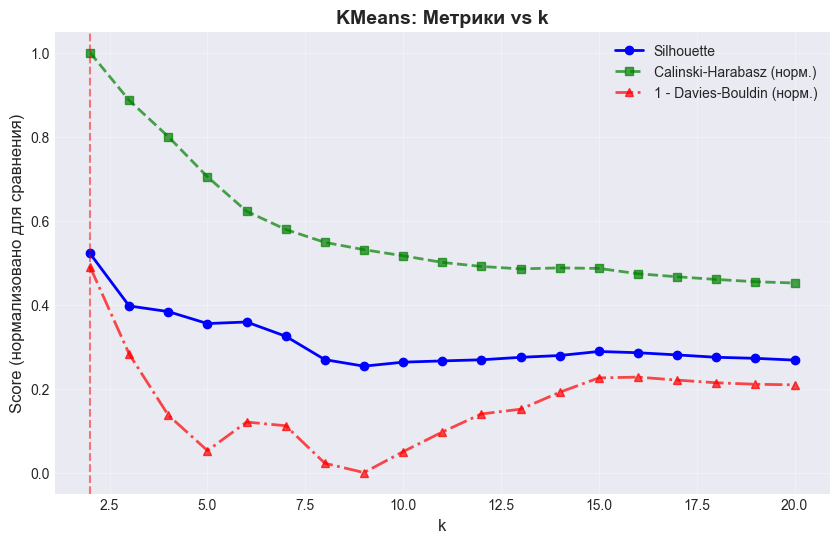


2. AgglomerativeClustering анализ...


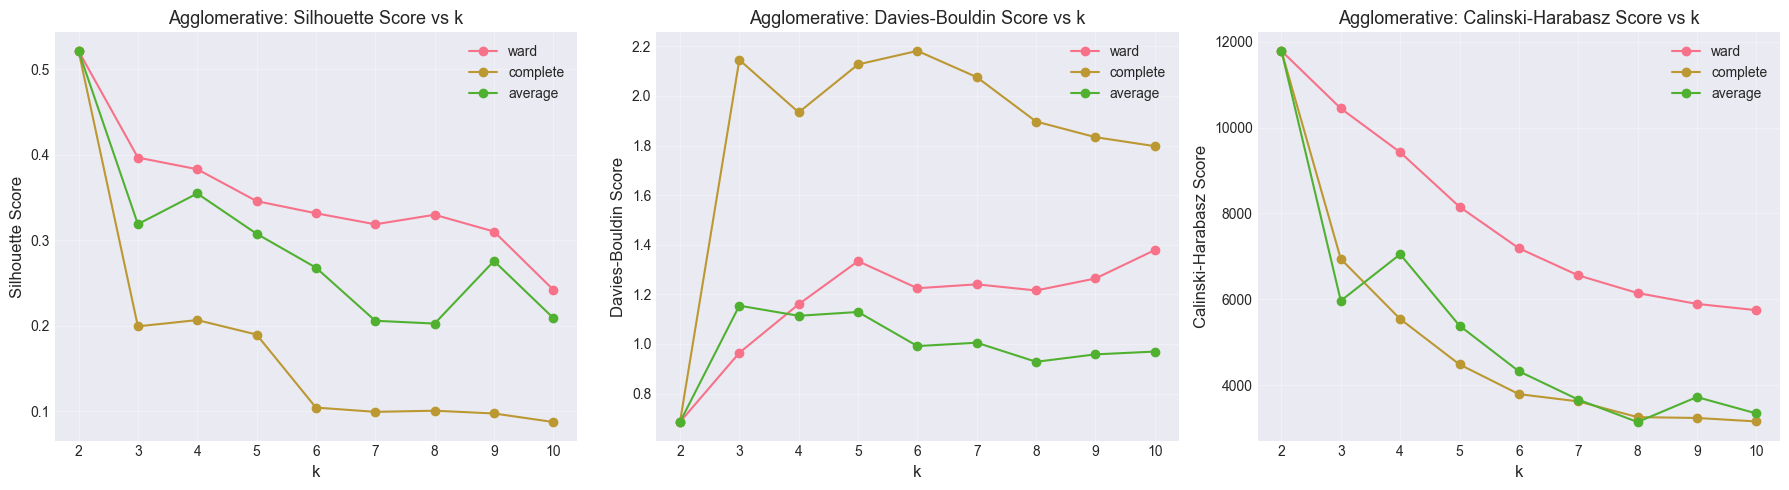


5. Визуализация лучшего метода: AgglomerativeClustering


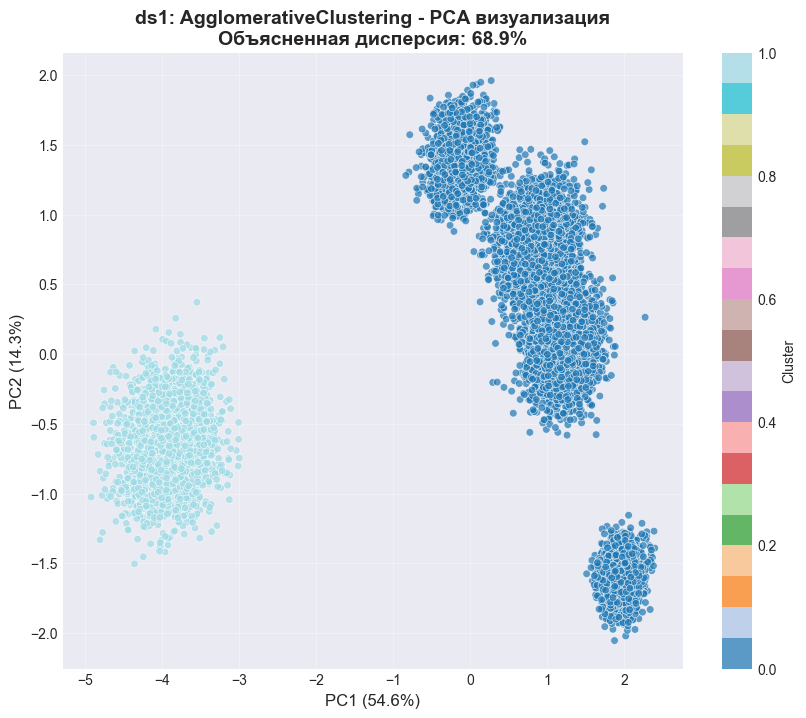

  Метки сохранены: artifacts\labels\labels_hw07_ds1.csv

ИТОГ ПО ДАТАСЕТУ: ds1

Метрики качества:

KMeans:
  silhouette_score: 0.5216
  davies_bouldin_score: 0.6853
  calinski_harabasz_score: 11786.9546

AgglomerativeClustering:
  silhouette_score: 0.5216
  davies_bouldin_score: 0.6853
  calinski_harabasz_score: 11786.9546

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'ward'}

Анализ результатов:
2. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.522
3. Davies-Bouldin score: 0.685 (чем меньше, тем лучше)
4. Calinski-Harabasz score: 11787.0 (чем больше, тем лучше)
5. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
6. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
7. Рекомендация: для данного датасета оптимальное число кластеров: 2

АНАЛИЗ ДАТАСЕТА: ds2

1. KMeans анализ...


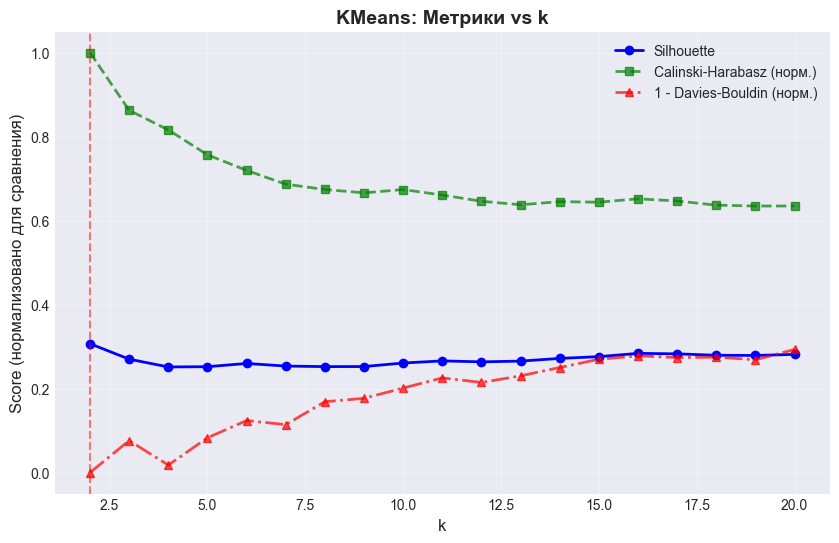


2. AgglomerativeClustering анализ...


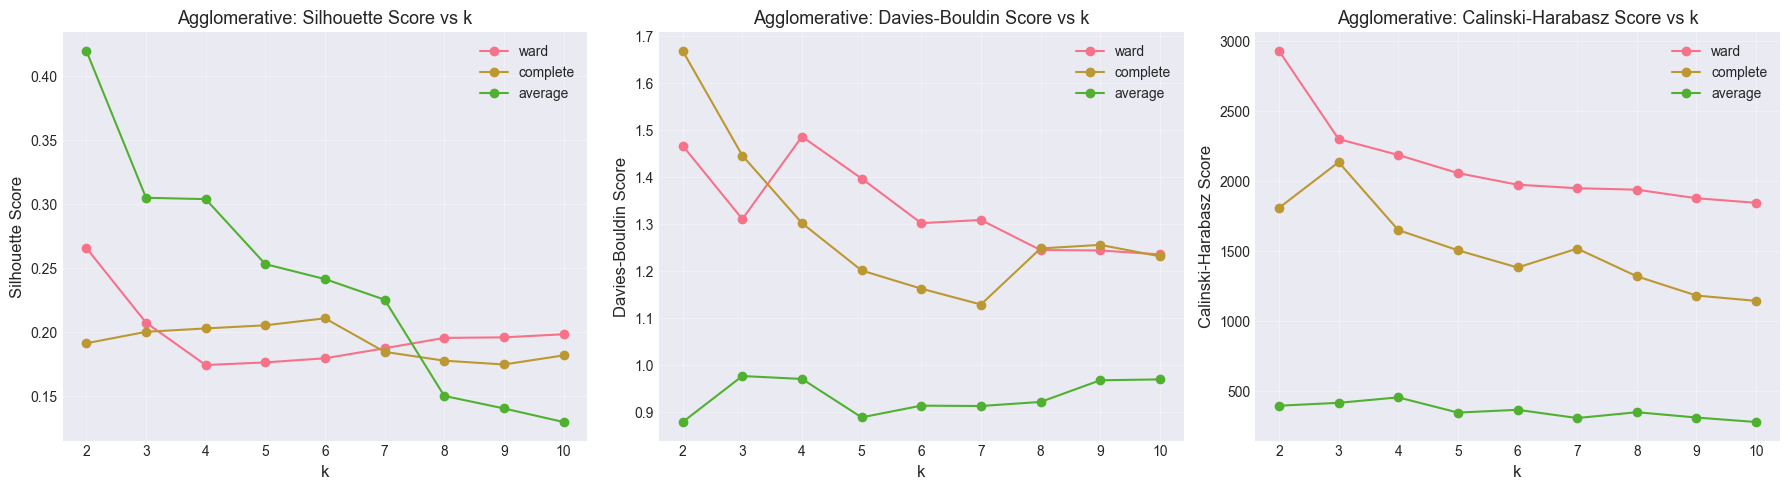


5. Визуализация лучшего метода: AgglomerativeClustering


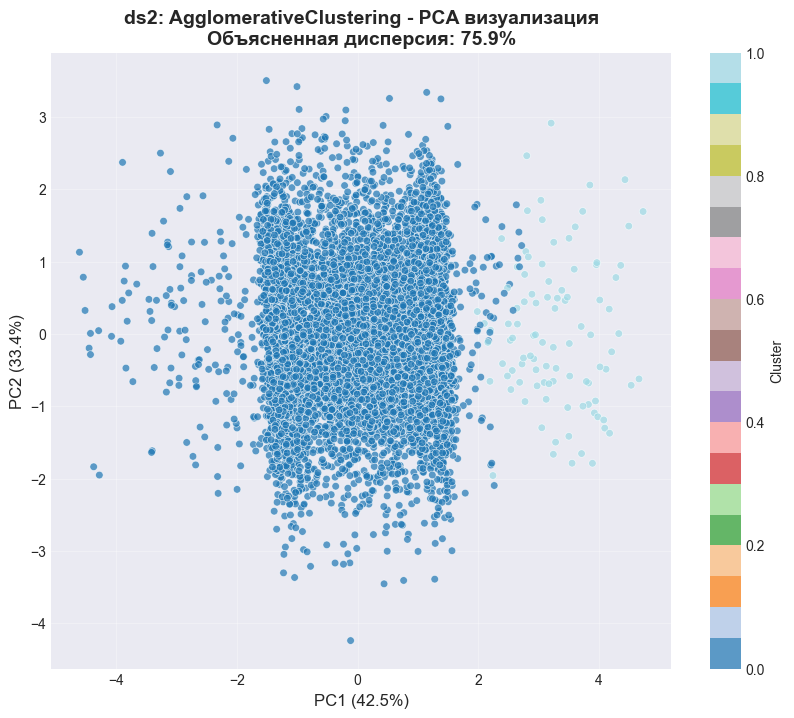

  Метки сохранены: artifacts\labels\labels_hw07_ds2.csv

ИТОГ ПО ДАТАСЕТУ: ds2

Метрики качества:

KMeans:
  silhouette_score: 0.3069
  davies_bouldin_score: 1.3235
  calinski_harabasz_score: 3573.3933

AgglomerativeClustering:
  silhouette_score: 0.4198
  davies_bouldin_score: 0.8791
  calinski_harabasz_score: 395.4826

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'average'}

Анализ результатов:
2. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.420
3. Davies-Bouldin score: 0.879 (чем меньше, тем лучше)
4. Calinski-Harabasz score: 395.5 (чем больше, тем лучше)
5. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
6. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
7. Рекомендация: для данного датасета оптимальное число кластеров: 2

АНАЛИЗ ДАТАСЕТА: ds3

1. KMeans анализ...


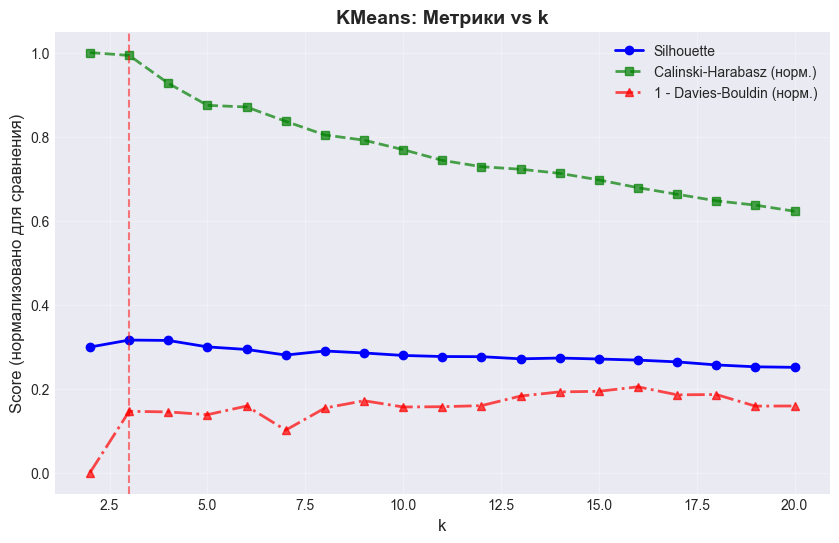


2. AgglomerativeClustering анализ...


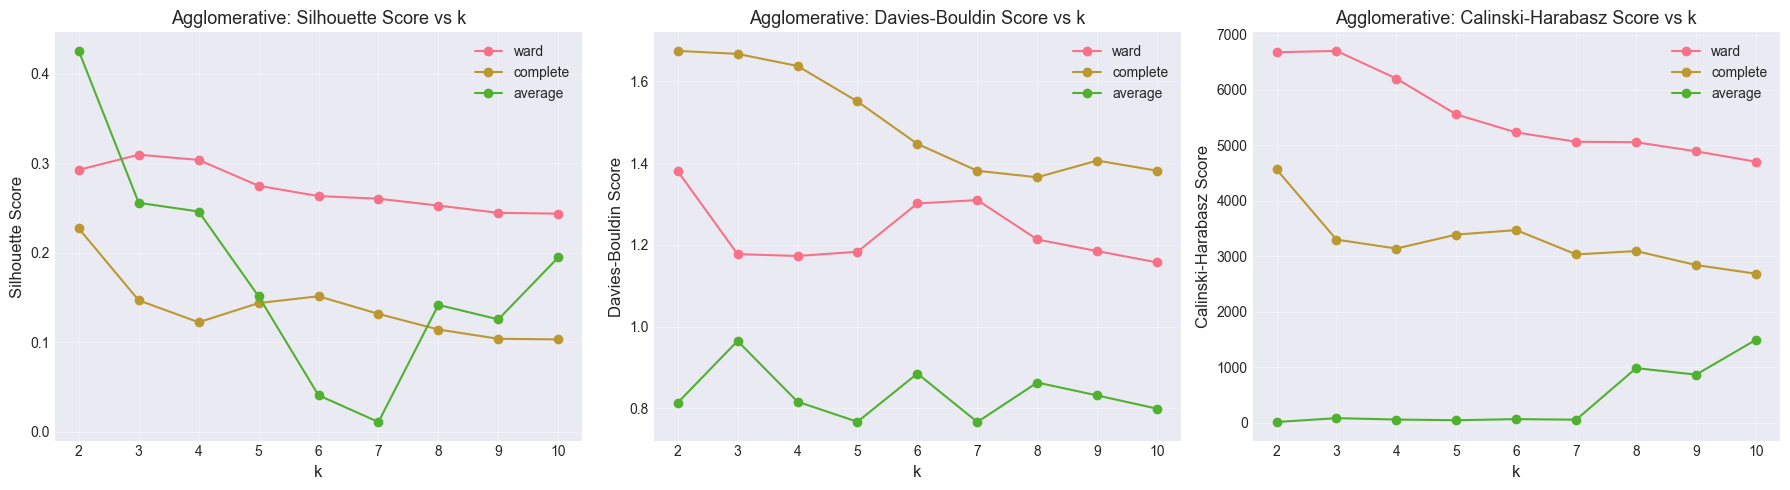


5. Визуализация лучшего метода: AgglomerativeClustering


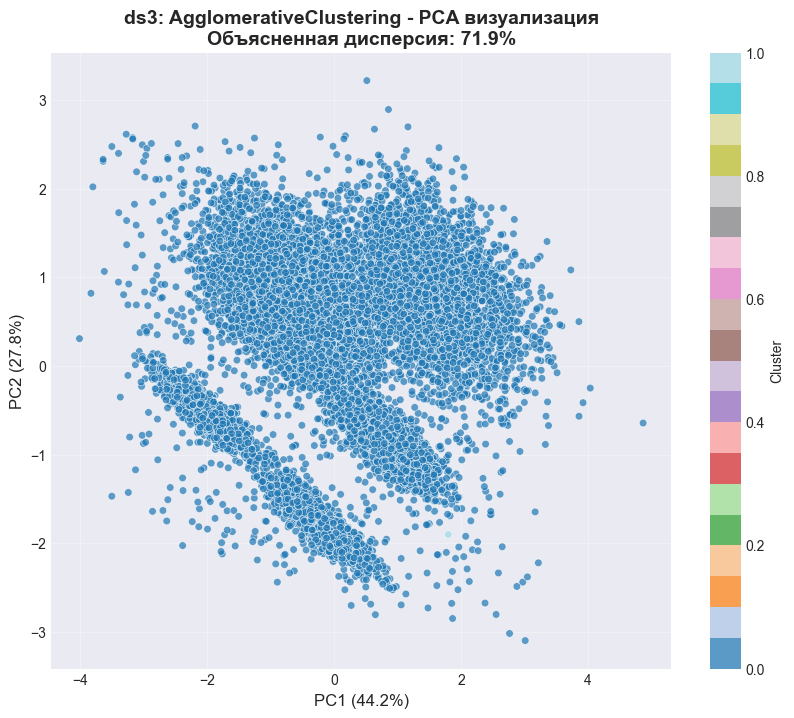

  Метки сохранены: artifacts\labels\labels_hw07_ds3.csv

ИТОГ ПО ДАТАСЕТУ: ds3

Метрики качества:

KMeans:
  silhouette_score: 0.3155
  davies_bouldin_score: 1.1577
  calinski_harabasz_score: 6957.1626

AgglomerativeClustering:
  silhouette_score: 0.4253
  davies_bouldin_score: 0.8138
  calinski_harabasz_score: 8.9431

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'average'}

Анализ результатов:
2. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.425
3. Davies-Bouldin score: 0.814 (чем меньше, тем лучше)
4. Calinski-Harabasz score: 8.9 (чем больше, тем лучше)
5. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
6. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
7. Рекомендация: для данного датасета оптимальное число кластеров: 2


In [60]:
datasets = [
    (X1_processed, sample_id_df1, "ds1"),
    (X2_processed, sample_id_df2, "ds2"), 
    (X3_processed, sample_id_df3, "ds3")
]

for X, sample_id, dataset_name in datasets:
    metrics, config = analyze_dataset(X, sample_id, dataset_name)

In [61]:
save_results()


РЕЗУЛЬТАТЫ СОХРАНЕНЫ:
1. metrics_summary.json: artifacts\metrics_summary.json
2. best_configs.json: artifacts\best_configs.json
3. Метки кластеров: artifacts\labels
4. Графики: artifacts\figures


============================================================
ИТОГ ПО ДАТАСЕТУ: ds1
============================================================

Метрики качества:

KMeans:
  * silhouette_score: 0.5216
  * davies_bouldin_score: 0.6853
  * calinski_harabasz_score: 11786.9546

AgglomerativeClustering:
  * silhouette_score: 0.5216
  * davies_bouldin_score: 0.6853
  * calinski_harabasz_score: 11786.9546

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'ward'}

Анализ результатов:
1. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.522
2. Davies-Bouldin score: 0.685 (чем меньше, тем лучше)
3. Calinski-Harabasz score: 11787.0 (чем больше, тем лучше)
4. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
5. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
6. Рекомендация: для данного датасета оптимальное число кластеров: 2

============================================================
ИТОГ ПО ДАТАСЕТУ: ds2
============================================================

Метрики качества:

KMeans:
  * silhouette_score: 0.3069
  * davies_bouldin_score: 1.3235
  * calinski_harabasz_score: 3573.3933

AgglomerativeClustering:
  * silhouette_score: 0.4198
  * davies_bouldin_score: 0.8791
  * calinski_harabasz_score: 395.4826

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'average'}

Анализ результатов:
1. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.420
2. Davies-Bouldin score: 0.879 (чем меньше, тем лучше)
3. Calinski-Harabasz score: 395.5 (чем больше, тем лучше)
4. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
5. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
6. Рекомендация: для данного датасета оптимальное число кластеров: 2

============================================================
ИТОГ ПО ДАТАСЕТУ: ds3
============================================================

Метрики качества:

KMeans:
  * silhouette_score: 0.3155
  * davies_bouldin_score: 1.1577
  * calinski_harabasz_score: 6957.1626

AgglomerativeClustering:
  * silhouette_score: 0.4253
  * davies_bouldin_score: 0.8138
  * calinski_harabasz_score: 8.9431

Лучший метод: AgglomerativeClustering
Параметры: {'n_clusters': 2, 'linkage': 'average'}

Анализ результатов:
1. Лучший метод (AgglomerativeClustering) показал silhouette score: 0.425
2. Davies-Bouldin score: 0.814 (чем меньше, тем лучше)
3. Calinski-Harabasz score: 8.9 (чем больше, тем лучше)
4. Выбранный метод AgglomerativeClustering уместен, так как показал наилучший баланс метрик.
5. Сложности: работа со шкалами решена StandardScaler, выбросы могут влиять на метрики.
6. Рекомендация: для данного датасета оптимальное число кластеров: 2

In [63]:
def check_kmeans_stability(X, n_clusters, n_runs=5):
    """Проверка устойчивости KMeans кластеризации"""
    labels_list = []
    silhouette_scores = []
    
    # 5 запусков с разными random_state
    random_states = [42, 123, 789, 2023, 404]
    
    for i, rs in enumerate(random_states):
        kmeans = KMeans(n_clusters=n_clusters, random_state=rs, n_init=10)
        labels = kmeans.fit_predict(X)
        labels_list.append(labels)
        
        sil_score = silhouette_score(X, labels)
        silhouette_scores.append(sil_score)
        print(f"Запуск {i+1} (rs={rs}): silhouette = {sil_score:.4f}")
    
    # Вычисляем попарные ARI
    ari_values = []
    for i in range(n_runs):
        for j in range(i+1, n_runs):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_values.append(ari)
    
    # Статистика
    print(f"\nСтатистика ARI:")
    print(f"  Среднее: {np.mean(ari_values):.4f}")
    print(f"  Станд. отклонение: {np.std(ari_values):.4f}")
    print(f"  Диапазон: [{np.min(ari_values):.4f}, {np.max(ari_values):.4f}]")
    
    print(f"\nСтатистика silhouette:")
    print(f"  Среднее: {np.mean(silhouette_scores):.4f}")
    print(f"  Станд. отклонение: {np.std(silhouette_scores):.4f}")
    
    # Оценка устойчивости
    if np.mean(ari_values) > 0.9 and np.std(silhouette_scores) < 0.05:
        print("\nВысокая устойчивость (стабильные разбиения)")
    elif np.mean(ari_values) > 0.7:
        print("\nУмеренная устойчивость")
    else:
        print("\nНизкая устойчивость (сильная зависимость от инициализации)")
    
    return {
        'mean_ari': np.mean(ari_values),
        'std_ari': np.std(ari_values),
        'mean_silhouette': np.mean(silhouette_scores),
        'std_silhouette': np.std(silhouette_scores)
    }

In [64]:
results = check_kmeans_stability(X1_processed, n_clusters=2)

Запуск 1 (rs=42): silhouette = 0.5216
Запуск 2 (rs=123): silhouette = 0.5216
Запуск 3 (rs=789): silhouette = 0.5216
Запуск 4 (rs=2023): silhouette = 0.5216
Запуск 5 (rs=404): silhouette = 0.5216

Статистика ARI:
  Среднее: 1.0000
  Станд. отклонение: 0.0000
  Диапазон: [1.0000, 1.0000]

Статистика silhouette:
  Среднее: 0.5216
  Станд. отклонение: 0.0000

Высокая устойчивость (стабильные разбиения)
